# Autonomous Driving - Car Detection

This is an application of YOLO based on [Redmon et al., 2016](https://arxiv.org/abs/1506.02640) and [Redmon and Farhadi, 2016](https://arxiv.org/abs/1612.08242) for Car Detection. Here we are implementing non-max supression, intersectio over union, YOLO evaluation and handing bounding box annotation. The dataset used here is from [drive.ai](https://www.drive.ai/).

## Table of Contents

- [Packages](#0)
- [1 - Thresholding](#1)
- [2 - Non-max supression with Intersection over Union](#2)
- [3 - Non-max supression with TensorFlow](#3)
- [4 - Load YOLO model](#4)
- [5 - Predict on a single Image](#5)
- [6 - Predict on a list of Images](#6)
- [7 - Convert to Video](#7)
- [8 - References](#8)

### Initial Setup

Run the following cell if data is uploaded as a zipfile to colab session.

In [4]:
import zipfile

# create a ZipFile object
zip_obj = zipfile.ZipFile("yad2k.zip")

# extract all the files to the current directory
zip_obj.extractall()

# close the ZipFile object
zip_obj.close()

If you are using colab, run the following cell. Otherwise manually download the `variables.data-00000-of-00001` file from [this link](https://drive.google.com/file/d/12vnLyYlZ-3QUtTRvQn_bJwQzWTkVi80i/view?usp=drive_link) and move it to the `./model_data/variables` directory.

In [ ]:
!gdown 12vnLyYlZ-3QUtTRvQn_bJwQzWTkVi80i
!mv variables.data-00000-of-00001 ./model_data/variables/variables.data-00000-of-00001

<a name='0'></a>
## Packages

Run the following cell to load the packages and dependencies that will come in handy as you build the object detector!

In [5]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor

from tensorflow.keras.models import load_model
from yad2k.models.keras_yolo import yolo_head
from yad2k.utils.utils import draw_boxes, get_colors_for_classes, scale_boxes, read_classes, read_anchors, preprocess_image

%matplotlib inline

<a name='1'></a>
### 1 - Filter out the bounding boxes with low confidence

In [6]:
def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
        boxes -- tensor of shape (19, 19, 5, 4)
        box_confidence -- tensor of shape (19, 19, 5, 1)
        box_class_probs -- tensor of shape (19, 19, 5, 80)
        threshold -- real value, if [ highest class probability score < threshold],
                     then get rid of the corresponding box

    Returns:
        scores -- tensor of shape (None,), containing the class probability score for selected boxes
        boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes

    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    # Compute box scores
    box_scores = box_confidence * box_class_probs

    # Find the box_classes using the max box_scores, keep track of the corresponding score
    box_classes = tf.math.argmax(box_scores, axis = -1)
    box_class_scores = tf.math.reduce_max(box_scores, axis = -1)
    
    # Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    filtering_mask = box_class_scores >= threshold
    
    # Apply the mask to box_class_scores, boxes and box_classes
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

<a name='2'></a>
### 2 - Non-max Suppression 

To remove a lot of overlapping bounding boxes, bounding boxes overlapping with a high cofidence bounding boxes can be removed. This is based on __"Intersection over Union"__ or IoU. 

In [7]:
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """


    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2

    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = max(box1_x1, box2_x1)
    yi1 = max(box1_y1, box2_y1)
    xi2 = min(box1_x2, box2_x2)
    yi2 = min(box1_y2, box2_y2)
    inter_width = xi2 - xi1
    inter_height =  yi2 - yi1
    inter_area = max(inter_width,0) * max(inter_height,0)
    
    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1_x2 - box1_x1)*(box1_y2 - box1_y1) 
    box2_area = (box2_x2 - box2_x1)*(box2_y2 - box2_y1) 
    union_area = box1_area + box2_area - inter_area
    
    # compute the IoU
    iou = inter_area/union_area
    
    return iou

<a name='3'></a>
### 3 - YOLO Non-max Suppression
Use standard `tf.image.non_max_supression` function to implement non max supression for YOLO.

In [8]:

def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None, ), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()

    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold = iou_threshold)
    
    # Use tf.gather() to select only nms_indices from scores, boxes and classes
    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    
    return scores, boxes, classes

#### YOLO Eval
takes a YOLO model output filters out the unwanted bounding boxes and returns scores, bounding boxes and classes for remaining bounding boxes.


In [9]:
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])


In [10]:
def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    # Retrieve outputs of the YOLO model (≈1 line)
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    
    # Convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    
    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)
    
    # Use one of the functions you've implemented to perform Non-max suppression with 
    # maximum number of boxes set to max_boxes and a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes,max_boxes, iou_threshold = iou_threshold)
    
    return scores, boxes, classes

<a name='4'></a>
### 4 - Load Pretrained YOLO and Predict

#### Defining Classes, Anchors and Image Shape

The model can classify 80 classes and uses 5 anchor boxes defined in the flies coco_classes.txt and yolo_anchors.txt respectively.

In [11]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
model_image_size = (608, 608) # Same as yolo_model input layer size

#### Loading a Pre-trained Model

A pretrained model with weights in the file "yolo.h5" can be loaded, which come from the official YOLO website, and were converted using a function written by Allan Zelener.

In [12]:
yolo_model = load_model("model_data/", compile=False)

Let's print the model summary.

In [13]:
yolo_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 608, 608, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 608, 608, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                      

<a name = "5"></a>
### 5 - Make prediction on an Image

In [14]:
def predict(image_file, images_only = False):
    """
    Runs the graph to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    
    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

    if not images_only:
        # Print predictions info
        print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
        
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    #draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=100)
    # Display the results in the notebook
    output_image = Image.open(os.path.join("out", image_file))
    
    if not images_only:
        imshow(output_image)
        return out_scores, out_boxes, out_classes
    else:
        return output_image

Run the following cell on the "test.jpg" image to verify that your function is correct.

Found 10 boxes for images/test.jpg
car 0.89 (367, 300) (745, 648)
car 0.80 (761, 282) (942, 412)
car 0.74 (159, 303) (346, 440)
car 0.70 (947, 324) (1280, 705)
bus 0.67 (5, 266) (220, 407)
car 0.66 (706, 279) (786, 350)
car 0.60 (925, 285) (1045, 374)
car 0.44 (336, 296) (378, 335)
car 0.37 (965, 273) (1022, 292)
traffic light 0.36 (681, 195) (692, 214)


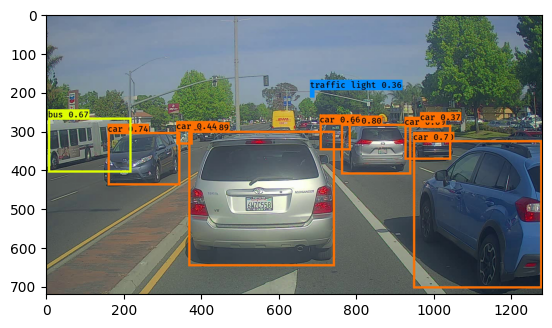

In [18]:
out_scores, out_boxes, out_classes = predict("test.jpg")

<a name = "6"></a>
### 6 - Predict on Multiple Images

In [ ]:
imgs = [i for i in os.listdir("images") if i.startswith("0")]
imgs.sort(key = lambda x: int(x.split(".")[0]))
imgs[:5]

images = list(map(lambda x: predict(x, True), imgs))

<a name = "7"></a>
### 7 - Export to Video/gif

#### Save as gif

In [ ]:
images[0].save('video.gif', save_all=True, optimize=False, append_images=images[1:], loop=0)

#### Display gif

In [ ]:
images[0].save('video.gif', save_all=True, optimize=False, append_images=images[1:], loop=0)
from ipywidgets import Video
Video.from_file('video.gif')

#### Save as MP4

In [45]:
imgs = [i for i in os.listdir("out") if i.startswith("0")]
imgs.sort(key = lambda x: int(x.split(".")[0]))
imgs[:5]

['0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg', '0005.jpg']

In [51]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from ipywidgets import Video

# Get the first image file and read its dimensions
first_image_file = os.path.join("out", imgs[0])
first_image = cv2.imread(first_image_file)
height, width, channels = first_image.shape
frame_rate = 5

video = cv2.VideoWriter('video.mp4', cv2.VideoWriter_fourcc(*"mp4v"), frame_rate, (width, height))

# Loop through the image files
for image_file in imgs:
    # Read the image file and add it to the video
    #image_file = os.path.join(input_folder, image_file)
    image_file = os.path.join("out", image_file)
    image = cv2.imread(image_file)
    video.write(image)

# Release the video writer object
video.release()


### Display MP4

In [52]:
Video.from_file('video.mp4')

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x01\x01\x9aZmdat\x00\x0…

<a name='8'></a>
### 8 - References 

This is a remix of notebook from [Deeplearning.ai](https://www.deeplearning.ai/). Other references are:

- Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2015)
- Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)
- Allan Zelener - [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
- The official YOLO website (https://pjreddie.com/darknet/yolo/) 

- [Convolution Neural Network: DeepLearning.ai](https://www.coursera.org/learn/convolutional-neural-networks/programming/3VCFG/car-detection-with-yolo)
### Car detection dataset

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The Drive.ai Sample Dataset</span> (provided by drive.ai) is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.